In [83]:
from src.dataset._dataset_utils import create_datasets


ds_names = ['atnf', 'biaf', 'bivi', 'cycc', 'vtak']

SEQ_LEN = 30
LOG_SPLITS = False
FIXED_SCALING = [(7, 3000.), (8, 12.), (9, 31.)]
ROOT = './data/clean'

datasets = { x: create_datasets(x, ROOT, FIXED_SCALING, LOG_SPLITS) for x in ds_names }

[autoreload of src.models.lnn failed: Traceback (most recent call last):
  File "c:\Users\killy\.conda\envs\dl-group-project\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\killy\.conda\envs\dl-group-project\Lib\site-packages\IPython\extensions\autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "c:\Users\killy\.conda\envs\dl-group-project\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "c:\Users\killy\.conda\envs\dl-group-project\Lib\site-packages\IPython\extensions\autoreload.py", line 349, in update_class
    if update_generic(old_obj, new_obj):
       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\killy\.conda\envs\dl-group-project\Lib\site-packages\IPython\extensions\autoreload.py", line 397, in update_generic
    update(a, b)
  File "c:\Users\killy\.conda\envs\dl-group-project\Lib\site-packages\IPython\e

In [84]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
LR = 1e-2
BETAS = (0.9, 0.999)
EPS = 1e-7
WEIGHT_DECAY=1e-5

GAMMA = 0.1
STEP_SIZE = 0.1
MILESTONES = [5, 10, 15]
MIN_LR = 1e-5
CRITERION_GAMMA=2.0

OPTIMIZER = 'adam' # 'adam' or 'sgd'
SCHEDULER = 'step' # 'plateau', 'step', or 'multi'
CRITERION = 'ce'   # 'ce' or 'cb_focal'

BATCH_SIZE = 16
HIDDEN_SIZE = 32

EPOCHS = 40

data='atnf'

print(datasets[data][0][0][0].shape)

input_size = datasets[data][0][0][0].shape[1]
train_label_ct = datasets[data][0].target_counts


torch.Size([10, 22])


In [99]:
from typing import Optional
from src.cbfocal_loss import FocalLoss
from src.models.abstract_model import AbstractModel


def get_optimizer(type: str, model: AbstractModel, lr, **kwargs):
  match type:
    case 'adam':
      return torch.optim.Adam(
        model.parameters(),
        lr=lr,
        **kwargs,
      )
    case 'sgd':
      return torch.optim.SGD(
        model.parameters(),
        lr=lr,
        **kwargs,
      )
    case _:
      raise ValueError(f'Unknown optimizer: {type}')
  

def get_scheduler(type: str, optimizer: torch.optim.Optimizer, **kwargs):
  match type:
    case 'plateau':
      return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **kwargs)
    case 'step':
      return torch.optim.lr_scheduler.StepLR(optimizer, **kwargs)
    case 'multi':
      return torch.optim.lr_scheduler.MultiStepLR(optimizer, **kwargs)
    case _:
      raise ValueError(f'Unknown scheduler: {type}')
    

def get_criterion(type: str, train_label_ct: Optional[torch.Tensor] = None, device='cpu', **kwargs):
  match type:
    case 'ce':
      weight = None
      if train_label_ct is not None:
        weight = train_label_ct.max() / train_label_ct
        weight = weight / weight.sum()
        weight = weight.to(device)

      return torch.nn.CrossEntropyLoss(
        weight=weight,
      )
    case 'cb_focal':
      return FocalLoss(
        class_counts=train_label_ct.to(device),
        **kwargs,
      )


In [100]:
%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader


ds_train, ds_valid, ds_test = datasets[data]

train_loader, valid_loader, test_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True), DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=False), DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import numpy as np


def train(
    model: AbstractModel,
    dataloader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: torch.nn.CrossEntropyLoss | FocalLoss,
    device: torch.device,
    epoch: int,
    writer: SummaryWriter = None,
  ):
  model.train()

  losses = np.zeros(len(dataloader))

  for idx, data in enumerate(dataloader):
    x = data[0].to(device)
    y = data[1].to(device)

    optimizer.zero_grad()
    logits: torch.Tensor = model(x)

    if len(logits.shape) == 1:
      logits = logits.unsqueeze(0)

    loss = criterion(logits, y)

    loss.backward()
    #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    if writer is not None:
      for l, (name, param) in enumerate(model.named_parameters()):
        if param.grad is not None:
          writer.add_scalar(f'Gradients/{l:02}_{name}', param.grad.norm().item(), epoch * len(dataloader) + idx)

    losses[idx] = loss.item()

  return losses.sum(), losses.mean()



In [102]:
from sklearn.metrics import f1_score


def evaluate(
    model: AbstractModel,
    dataloader: DataLoader,
    criterion: torch.optim.Optimizer,
    device: torch.device = 'cpu',
):
  losses = np.zeros(len(dataloader))
  accuracies = np.zeros(len(dataloader))

  all_preds = []
  all_labels = []
  with torch.no_grad():
    for idx, data in enumerate(dataloader):
      x = data[0].to(device)
      y = data[1].to(device)

      logits = model(x)

      preds = torch.argmax(logits, dim=1)
      all_preds.append(preds)
      all_labels.append(y)

      losses[idx] = criterion(logits, y).item()
      accuracies[idx] = torch.sum(torch.argmax(logits, dim=1) == y).item() / y.shape[0]

  all_preds = torch.cat(all_preds).cpu()
  all_labels = torch.cat(all_labels).cpu()

  classes, counts = torch.unique(all_preds, return_counts=True)
  pred_dist = torch.zeros(3)
  pred_dist[classes] = counts / counts.sum()

  f1_weighted = f1_score(all_labels, all_preds, average='weighted')

  return losses.sum(), losses.mean(), accuracies.mean(), f1_weighted, pred_dist

In [103]:
# ncps version
from src.models.lnn import LNN_2 

train_losses = np.zeros(EPOCHS)
valid_losses = np.zeros(EPOCHS)
writer = SummaryWriter(log_dir=f"../data/tensorboard/testing_2")

ltc = LNN_2(BATCH_SIZE, input_size, HIDDEN_SIZE, 3, n_layers=6, use_mixed=True).to(device)
optimizer = get_optimizer(OPTIMIZER, ltc, LR, betas=BETAS, eps=EPS)
scheduler = get_scheduler(SCHEDULER, optimizer, step_size=STEP_SIZE, gamma=GAMMA)
criterion = get_criterion(CRITERION, train_label_ct, device)


for epoch in range(EPOCHS):
  train_loss, train_loss_avg = train(ltc, train_loader, optimizer, criterion, device, epoch, writer=None)
  #scheduler.step(train_loss)
  scheduler.step()

  _, valid_loss_avg, _, _, v_pred_dist = evaluate(ltc, valid_loader, criterion, device=device)

  train_losses[epoch] = train_loss_avg
  valid_losses[epoch] = valid_loss_avg

  writer.add_scalar('Loss/train', train_loss_avg, epoch)
  writer.add_scalar('Loss/valid', valid_loss_avg, epoch)

  pred_string = ' - '.join([f'C{ix} {x:.3f}' for ix, x in enumerate(v_pred_dist)])
  #pb.set_description(
  #  f'E: {epoch + 1} | Train: {train_loss_avg:.4f} | Valid {valid_loss_avg:.4f} | V_Pred Dist: {pred_string}'
  #)
  #pb.update(1)
  print(f'E: {epoch + 1} | Train: {train_loss_avg:.4f} | Valid {valid_loss_avg:.4f} | V_Pred Dist: {pred_string}')

test_loss, test_loss_avg, test_acc, test_f1, test_pred_dist = evaluate(
    ltc,
    test_loader,
    criterion,
    device=device
)

E: 1 | Train: 1.1187 | Valid 1.0843 | V_Pred Dist: C0 0.000 - C1 0.000 - C2 1.000
E: 2 | Train: 1.0937 | Valid 1.0810 | V_Pred Dist: C0 0.000 - C1 0.000 - C2 1.000
E: 3 | Train: 1.1011 | Valid 1.0848 | V_Pred Dist: C0 0.377 - C1 0.000 - C2 0.623
E: 4 | Train: 1.0912 | Valid 1.0830 | V_Pred Dist: C0 0.877 - C1 0.000 - C2 0.123
E: 5 | Train: 1.0840 | Valid 1.0798 | V_Pred Dist: C0 0.148 - C1 0.000 - C2 0.852
E: 6 | Train: 1.0841 | Valid 1.1028 | V_Pred Dist: C0 0.000 - C1 0.492 - C2 0.508
E: 7 | Train: 1.0845 | Valid 1.0770 | V_Pred Dist: C0 0.426 - C1 0.000 - C2 0.574
E: 8 | Train: 1.0991 | Valid 1.0886 | V_Pred Dist: C0 0.082 - C1 0.123 - C2 0.795
E: 9 | Train: 1.0861 | Valid 1.0832 | V_Pred Dist: C0 0.000 - C1 0.000 - C2 1.000
E: 10 | Train: 1.0808 | Valid 1.0668 | V_Pred Dist: C0 0.230 - C1 0.000 - C2 0.770
E: 11 | Train: 1.0740 | Valid 1.0687 | V_Pred Dist: C0 0.025 - C1 0.000 - C2 0.975
E: 12 | Train: 1.0730 | Valid 1.1043 | V_Pred Dist: C0 0.131 - C1 0.615 - C2 0.254
E: 13 | Train

| Dataset  | 0: Sell | 1: Hold | 2: Buy |
|----------|---------|---------|--------|
| Test     |    0.31 |    0.03 |   0.66 |
|----------|---------|---------|--------|
0.4230769230769231


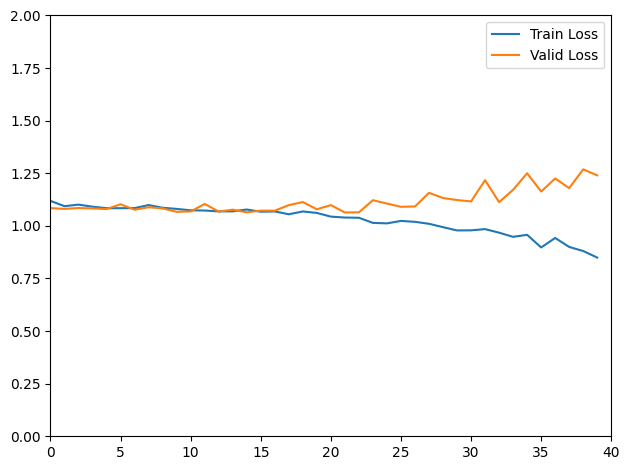

In [104]:
import matplotlib.pyplot as plt

from src.dataset._dataset_utils import print_target_distribution

print_target_distribution([("Test", test_pred_dist)])

print(test_acc)

plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
# Set y scale between 0.25 and 1.25
plt.xlim(0, EPOCHS)
plt.ylim(0.0, 2)
plt.legend()
plt.tight_layout()
plt.show()
plt.close()
